In [1]:
import pandas as pd
import numpy as np
import dtreeviz
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

#### Load data

In [2]:
data = pd.read_csv(".././data/data.csv")
# rename the columns to make it easier for accessing
new_col_names_map =  {i: i.lower().replace(" ", "_") for i in data.columns}
data = data.rename(columns=new_col_names_map)

# set the timestamp as the index for easy access of the data
data = data.set_index("time")

# subset the dataset to load only the post covid dataset
data = data[data.index >= "2021-01-01"]

# exclude certain columns
cols = [
    "year",
    "day_of_month",
    "forecast_datadate",
    "forecastperiod",
    "forecast_interval",
    "comms_and_services",
    "space_heating",
    "hot_water",
    "sockets",
    "lighting"
]
data = data.drop(columns=cols, axis=0)

# target variable
target = "bld_engcons"

data.head()

,bld_engcons,car_chargers,weekend,bank_holiday,hour,day_of_week,month,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_windspeed,forecast_uvindex,forecast_precipitationprobability,forecast_winddirection,forecast_visibility
time,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00,4.221002,0.0,False,True,0,5,1,3.0,-1.0,2.0,11.0,0.0,0.0,N,VG
2021-01-01 01:00:00+00,4.806708,0.0,False,True,1,5,1,3.0,-1.0,2.0,11.0,0.0,0.0,N,VG
2021-01-01 02:00:00+00,6.585732,0.0,False,True,2,5,1,3.0,-1.0,2.0,11.0,0.0,1.0,N,VG
2021-01-01 03:00:00+00,6.545530,0.0,False,True,3,5,1,2.0,-2.0,0.0,11.0,0.0,1.0,NNW,VG
2021-01-01 04:00:00+00,6.211650,0.0,False,True,4,5,1,2.0,-2.0,0.0,11.0,0.0,1.0,NNW,VG


#### Checking the missing data


In [3]:
data.isna().sum()

bld_engcons                            0
car_chargers                         444
weekend                                0
bank_holiday                           0
hour                                   0
day_of_week                            0
month                                  0
forecast_temperature                 578
forecast_feelslike                   578
forecast_weathertype                 578
forecast_windspeed                   578
forecast_uvindex                     578
forecast_precipitationprobability    578
forecast_winddirection               578
forecast_visibility                  578
dtype: int64

In [4]:
# filling the NA with mode values
data["forecast_visibility"] = data["forecast_visibility"].fillna(data["forecast_visibility"].mode())
data["forecast_winddirection"] = data["forecast_winddirection"].fillna(data["forecast_winddirection"].mode())

#### Apply Feature encoding
- Type of transformation: column names
- boolean transformation: `weekend, bank holiday`
- cyclic: `day_of_week, month, hour, winddirection`
- ordinal encoding: `forecastvisibility`

In [5]:
# boolean transformation
data["weekend"] = data["weekend"].astype(int)
data["bank_holiday"] = data["bank_holiday"].astype(int)

In [6]:
# forecast winddirection convertion to degrees 
data2 = data.copy()
degrees_map = pd.read_csv(".././data/degrees.csv", sep=",")
degrees_lookup = {abbrv: deg for abbrv, deg in zip(degrees_map["Abbrv."], degrees_map["Degrees"])}
data2["forecast_winddirection"] = data2["forecast_winddirection"].map(degrees_lookup)
data2["forecast_winddirection"].value_counts()

forecast_winddirection
247.5    3434
270.0    2747
225.0    2398
292.5    2311
90.0     1669
315.0    1667
112.5    1639
337.5    1594
202.5    1485
180.0    1245
0.0      1073
135.0    1062
67.5     1025
45.0      872
157.5     773
22.5      708
Name: count, dtype: int64

In [7]:
# cyclic transformations
denom_map = {
    "hour": 24, "month": 12, "day_of_week": 7, "forecast_winddirection": 360
}

for col_name in denom_map:
    print(col_name)
    data2[f"sine_{col_name}"] = np.sin(2 * np.pi * data2[col_name] / denom_map[col_name])
    data2[f"cos_{col_name}"] = np.cos(2 * np.pi * data2[col_name] / denom_map[col_name])


hour
month
day_of_week
forecast_winddirection


In [8]:
# transform the forecast visibility

# Reference
# https://www.metoffice.gov.uk/weather/guides/what-does-this-forecast-mean#:~:text=Visibility%20measures%20the%20distance%20at,Less%20than%201%2C000%20metres
visibility_map = {
    "EX": 6, "VG": 5, "GO": 4, "MO": 3, "PO": 2, "VP": 1
}

data2["forecast_visibility"] = data2["forecast_visibility"].map(visibility_map)
data2.head()

,bld_engcons,car_chargers,weekend,bank_holiday,hour,day_of_week,month,forecast_temperature,forecast_feelslike,forecast_weathertype,...,forecast_winddirection,forecast_visibility,sine_hour,cos_hour,sine_month,cos_month,sine_day_of_week,cos_day_of_week,sine_forecast_winddirection,cos_forecast_winddirection
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00,4.221002,0.0,0,1,0,5,1,3.0,-1.0,2.0,...,0.0,5.0,0.000000,1.000000,0.5,0.866025,-0.974928,-0.222521,0.000000,1.00000
2021-01-01 01:00:00+00,4.806708,0.0,0,1,1,5,1,3.0,-1.0,2.0,...,0.0,5.0,0.258819,0.965926,0.5,0.866025,-0.974928,-0.222521,0.000000,1.00000
2021-01-01 02:00:00+00,6.585732,0.0,0,1,2,5,1,3.0,-1.0,2.0,...,0.0,5.0,0.500000,0.866025,0.5,0.866025,-0.974928,-0.222521,0.000000,1.00000
2021-01-01 03:00:00+00,6.545530,0.0,0,1,3,5,1,2.0,-2.0,0.0,...,337.5,5.0,0.707107,0.707107,0.5,0.866025,-0.974928,-0.222521,-0.382683,0.92388
2021-01-01 04:00:00+00,6.211650,0.0,0,1,4,5,1,2.0,-2.0,0.0,...,337.5,5.0,0.866025,0.500000,0.5,0.866025,-0.974928,-0.222521,-0.382683,0.92388


In [9]:
data2.columns

Index(['bld_engcons', 'car_chargers', 'weekend', 'bank_holiday', 'hour',
       'day_of_week', 'month', 'forecast_temperature', 'forecast_feelslike',
       'forecast_weathertype', 'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_winddirection',
       'forecast_visibility', 'sine_hour', 'cos_hour', 'sine_month',
       'cos_month', 'sine_day_of_week', 'cos_day_of_week',
       'sine_forecast_winddirection', 'cos_forecast_winddirection'],
      dtype='object')

#### Perform data imputation

In [10]:
data2 = data2.drop(columns=["forecast_visibility", "forecast_winddirection", 
                            "car_chargers", "day_of_week", "hour"])

# fetch the list of columns that has missing values in them 
missing_columns = pd.DataFrame(data2.isna().sum().reset_index())
missing_columns = missing_columns[missing_columns[0] > 0]
missing_columns = missing_columns["index"].tolist()

# impute the data
for column in missing_columns:
    data2[column] = data2[column].interpolate(method="linear", limit_direction="both")

data2.isna().sum()

bld_engcons                          0
weekend                              0
bank_holiday                         0
hour                                 0
day_of_week                          0
month                                0
forecast_temperature                 0
forecast_feelslike                   0
forecast_weathertype                 0
forecast_windspeed                   0
forecast_uvindex                     0
forecast_precipitationprobability    0
sine_hour                            0
cos_hour                             0
sine_month                           0
cos_month                            0
sine_day_of_week                     0
cos_day_of_week                      0
sine_forecast_winddirection          0
cos_forecast_winddirection           0
dtype: int64

##### checkpoint the dataset

In [69]:
save_data = data2.reset_index()
save_data.to_csv(".././data/feature_data.csv", index=False)

#### Splitting data into train - test

In [20]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(data2, train_size=0.8, shuffle=False)
train.shape, test.shape

((21024, 20), (5256, 20))

In [22]:
validation, test = train_test_split(test, test_size=0.5, shuffle=False)
validation.shape

(2628, 20)

#### Regressor Tree visualization

CART: Classification and Regression Tree 

- Tree structures have `inbuilt feature selection`, it helps in understanding what features are considered. The leaf splits are done using the `Reduction in Variance` i.e. the feature that minimizes the SSE is considered for splitting

In [31]:
tree_regressor = DecisionTreeRegressor(
    max_depth=5, random_state=45, criterion="absolute_error"
)

target_col = "bld_engcons"
x_cols = list(set(train.columns) - set([target_col]))
tree_regressor.fit(train[x_cols].values, train[target_col].values)
tree_regressor

DecisionTreeRegressor(criterion='absolute_error', max_depth=5, random_state=45)

In [70]:
viz_rmodel = dtreeviz.model(
    model=tree_regressor, 
    X_train=train[x_cols], 
    y_train=train[target_col],
    feature_names=x_cols, 
    target_name=target_col)
viz_view = viz_rmodel.view(fancy=False)

In [71]:
viz_view.show()
viz_view.save(".././assets/dtree2.svg")

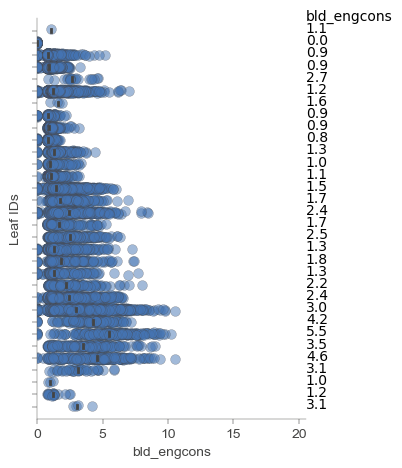

In [34]:
viz_rmodel.rtree_leaf_distributions()

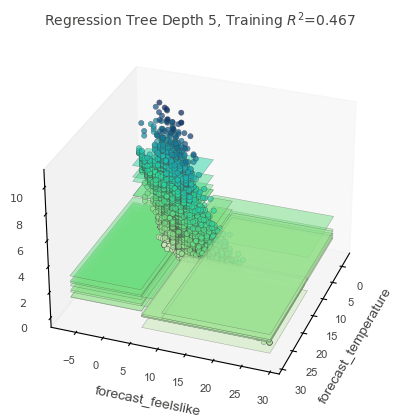

In [35]:
viz_rmodel.rtree_feature_space3D(features=['forecast_temperature','forecast_feelslike'],
                                 fontsize=10,
                                 elev=30, azim=20,
                                 show={'splits', 'title'},
                                 colors={'tessellation_alpha': .5})

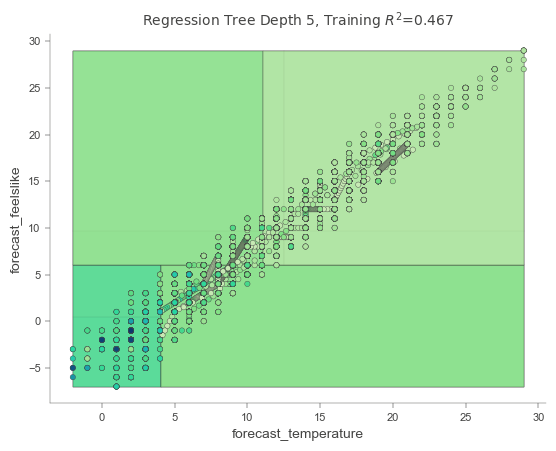

In [36]:
viz_rmodel.rtree_feature_space(features=['forecast_temperature','forecast_feelslike'])

In [37]:
predictions = tree_regressor.predict(validation[x_cols])

c:\Users\akson\anaconda3\envs\ra_env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names


In [44]:
plot_data = validation[[target_col]].rename(columns={"bld_engcons": "actual"})
plot_data["predictions"] = predictions.tolist()
plot_data.head()

,actual,predictions
time,,
2023-05-27 00:00:00+00,1.138030,0.933574
2023-05-27 01:00:00+00,1.174294,0.933574
2023-05-27 02:00:00+00,1.150049,0.933574
2023-05-27 03:00:00+00,1.120239,0.933574
2023-05-27 04:00:00+00,1.152939,0.933574


In [65]:
plot_data.loc[plot_data.index < "2023-05-31", :]

,actual,predictions
time,,
2023-05-27 00:00:00+00,1.138030,0.933574
2023-05-27 01:00:00+00,1.174294,0.933574
2023-05-27 02:00:00+00,1.150049,0.933574
2023-05-27 03:00:00+00,1.120239,0.933574
2023-05-27 04:00:00+00,1.152939,0.933574
...,...,...
2023-05-30 19:00:00+00,1.671535,0.933574
2023-05-30 20:00:00+00,2.147483,0.933574
2023-05-30 21:00:00+00,1.626899,0.933574


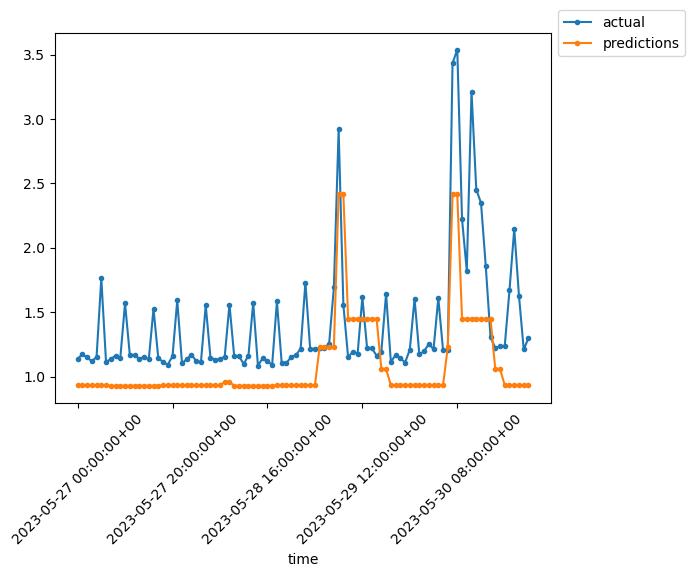

In [66]:
plot_data.loc[plot_data.index < "2023-05-31", :].plot(style=".-")
plt.legend(loc="center left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

In [53]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error

In [55]:
mean_absolute_error(plot_data["actual"], plot_data["predictions"])

0.39301290047146126

In [56]:
mean_absolute_percentage_error(plot_data["actual"], plot_data["predictions"])

48234004309007.664

In [57]:
root_mean_squared_error(plot_data["actual"], plot_data["predictions"])

0.5610873042268064

#### ML XAI

In [17]:
import shap